In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

In [2]:
WEEKDAYS_IN_YEAR = 261
DAYS_IN_MONTH = 20

dl = DataLib("SignalData")
BondReturnIdx = dl.pull("BondRetIdx/LocalFX")
fxvsusd = dl.pull("fxVsUSD")
equities = dl.pull("EquityPrices")
m1 = dl.pull("M1/inUSD")
m2 = dl.pull("M2/inUSD")
m3 = dl.pull("M3/inUSD")
curr_acct_nom = dl.pull("CurrAcctNom/inUSD")
curr_acct_gdp = dl.pull("CurrAcctPctGDP")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
fxNominal = dl.pull("fxTrdWts/Nominal")
fxReal = dl.pull("fxTrdWts/Real")
core_cpi = dl.pull("CoreCPI/SA")
gdp_real = dl.pull("GDP/Real")

#### Cross-Country Comparisons

We are still assuming 0 to be the mean/"normal": the economy/money supply continues to grow at its current rate. We are more interested in changes in monetary policy from the norm. 

Note: For most countries, the true mean tended to be very close to 0.

Change: Shifted away from using a constant historical average for the standard deviation --> standardizing each country based on their 5-year rolling standard deviation.

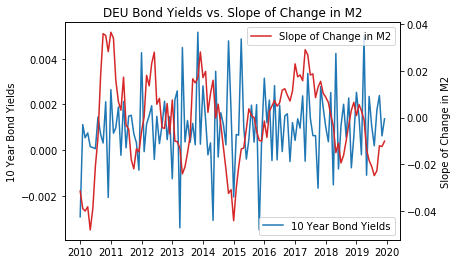

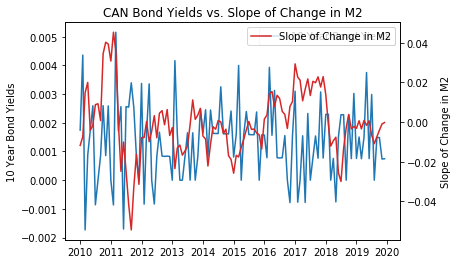

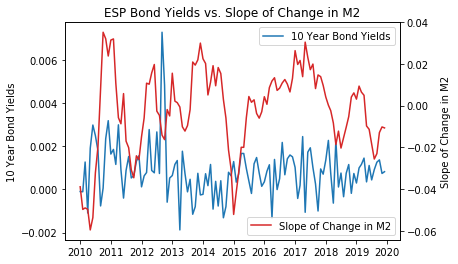

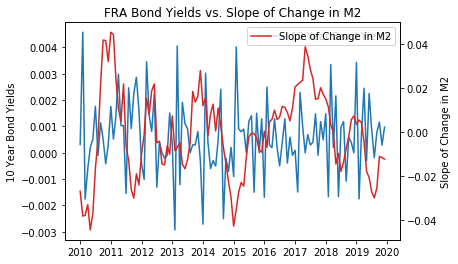

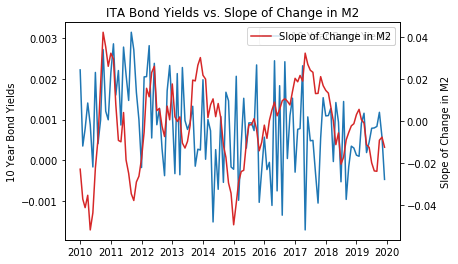

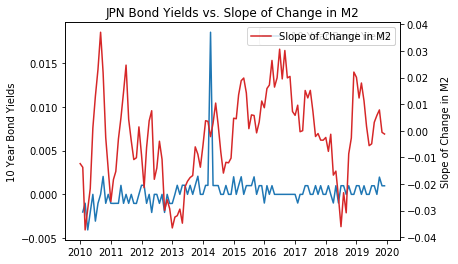

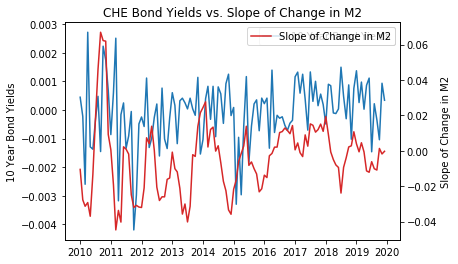

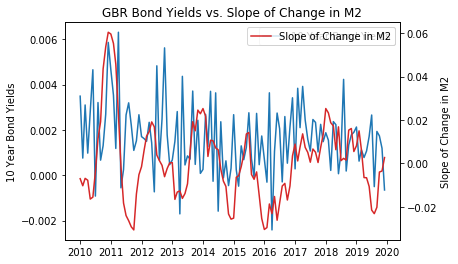

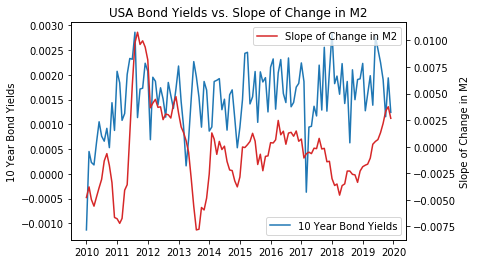

In [623]:
change_m2 = m2.pct_change(24)
smoothed_change_m2 = change_m2.rolling(6).mean()
slope_smoothed_change_m2 = smoothed_change_m2.diff()
rolling_slope = slope_smoothed_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_mean = rolling_slope.mean()
rolling_slope_std = rolling_slope.std()
upper_boundary_std = 0.5 * rolling_slope_std
lower_boundary_std = -0.5 * rolling_slope_std
start_date = '2010-01-01'
end_date = '2019-12-31'
for country in change_m2.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    # ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.plot(core_cpi.pct_change(1)[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Slope of Change in M2'
    ax2.plot(slope_smoothed_change_m2[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    std = slope_smoothed_change_m2_stds[country]
#     upper_boundary_std[country].loc[start_date:end_date].plot(color = 'green')
#     lower_boundary_std[country].loc[start_date:end_date].plot(color = 'green')
    plt.title(country + " Bond Yields vs. Slope of Change in M2")
    plt.show()

In [307]:
cross_country_standardized_slopes = slope_smoothed_change_m2/rolling_slope_std
cross_country_standardized_slopes.loc['2018-01-01'].sort_values(axis=0, ascending = False)

country
GBR    1.679962
CHE    1.178367
CAN    1.007014
FRA    0.875592
ITA    0.809631
DEU    0.530864
ESP    0.244004
JPN   -0.164073
USA   -1.309005
Name: 2018-01, dtype: float64

#### Measuring P&L and Bond Returns

Note: if the standardized slope is not 0.5 SD from 0, then hold the prior position.

failure case
country
USA    -0.000000
CAN    -0.000000
CHE    -0.000000
GBR    12.105900
DEU    24.718317
ESP    21.119762
ITA    17.960427
FRA    24.095594
JPN    -0.000000
Name: 2018-05, dtype: float64
country
DEU    0.006061
CAN    0.010093
ESP   -0.009153
FRA    0.003789
ITA   -0.035177
JPN    0.000291
CHE    0.005264
GBR    0.008473
USA    0.014512
Name: 2018-05-29, dtype: float64


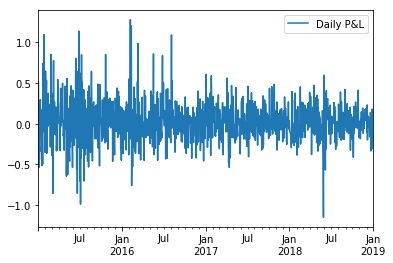

In [471]:
start_date = '1990-01-01'
end_date = '2015-01-01'
trade_date = '2015-01-02'
unwind_date = '2019-01-01'
trade_range = pd.date_range(trade_date, unwind_date, freq='B')
daily_pl = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily P&L"])
prior_weights = pd.Series()

minus_AUS_returns = BondReturnIdx.drop("AUS",axis=1)
long_returns = minus_AUS_returns.pct_change(1)
short_returns = minus_AUS_returns.pct_change(-1)

for date in pd.date_range(trade_date, unwind_date, freq='B').date:
    m2_training = m2.loc[start_date:end_date]
    change_m2_training = m2_training.pct_change(1)
    smoothed_m2_training = change_m2_training.rolling(3).mean()
    slope_change_m2_training = smoothed_m2_training.diff()

    #standardizing data across time 
    rolling_slope = slope_change_m2_training.rolling(5*12, min_periods = 12*2)
    rolling_slope_std = rolling_slope.std()
    time_standardized_slopes = slope_change_m2_training/rolling_slope_std
    current_slopes = time_standardized_slopes.loc[end_date].sort_values(axis=0, ascending = False)
    
    #hold prior position if the slope is < .5 standard deviations from 0
    if prior_weights.empty:
        prior_weights = current_slopes
    current_slopes = current_slopes.where(current_slopes.abs() > 0.5, prior_weights)
    
    #calculating long positions
    current_slopes_neg = current_slopes.multiply(current_slopes.lt(0))
    sum_neg_weights = current_slopes_neg.sum()
    if sum_neg_weights != 0:
        current_slopes_neg = current_slopes_neg / sum_neg_weights
    buy_amounts = current_slopes_neg * 100

    #calculating short positions
    current_slopes_pos = current_slopes.multiply(current_slopes.gt(0))
    sum_pos_weights = current_slopes_pos.sum()
    if sum_pos_weights != 0:
        current_slopes_pos = current_slopes_pos / sum_pos_weights
    sell_amounts = current_slopes_pos * 100
    
    #calculating return 
    one_day_long_return = long_returns.loc[date]
    one_day_short_return = short_returns.loc[end_date]
    daily_pl.loc[date] = buy_amounts.dot(one_day_long_return) + sell_amounts.dot(one_day_short_return)    
    
    #model testing - cases of very poor performance 
    if daily_pl.loc[date].values < -1:
        print("failure case")
        print(buy_amounts)
        print(one_day_long_return)
#         print(sell_amounts)
#         print(one_day_short_return)
#         print(current_slopes)
    end_date = date
    
daily_pl.plot()
plt.show()

In [452]:
total_pl = daily_pl.sum()
total_pl

Daily P&L    28.642396
dtype: float64

#### Investigating Failure Cases from Initial Iteration described in "Preliminary Signal Exploration"
- 2015-12-03
- 2015-05-05

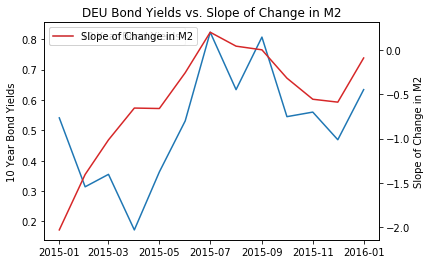

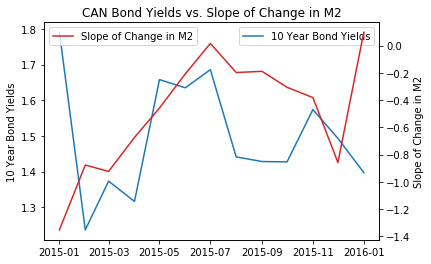

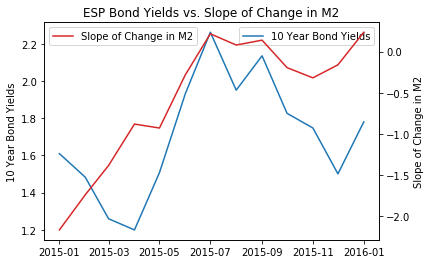

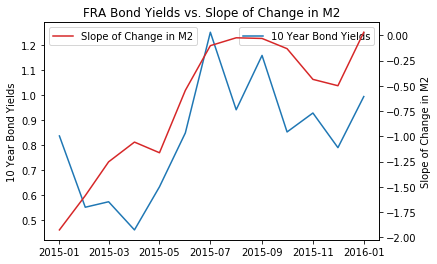

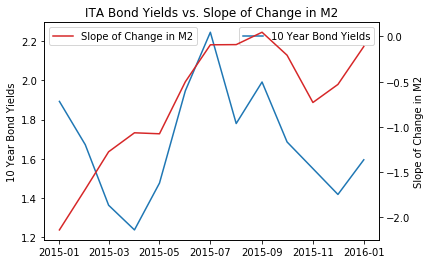

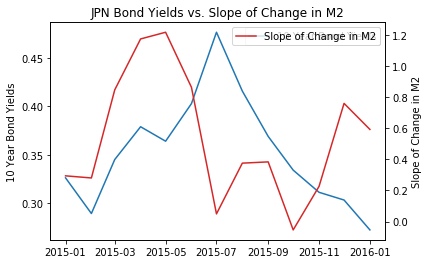

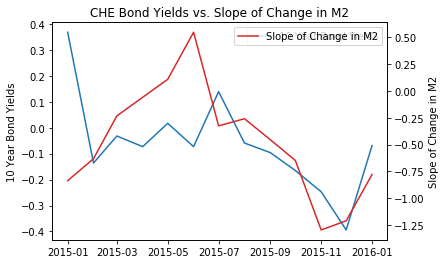

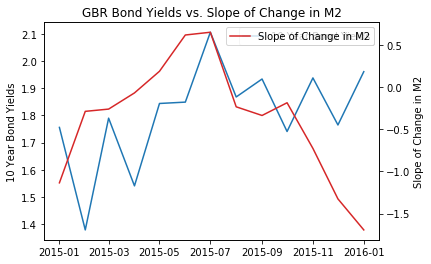

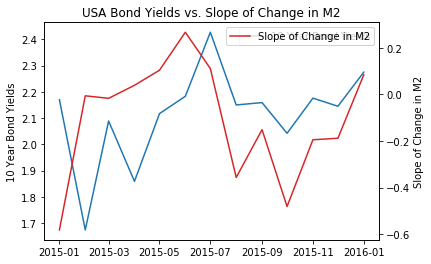

In [438]:
change_m2 = m2.pct_change(24)
smoothed_change_m2 = change_m2.rolling(6).mean()
slope_smoothed_change_m2 = smoothed_change_m2.diff()
rolling_slope = slope_smoothed_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_std = rolling_slope.std()
start_date = '2015-01-01'
end_date = '2016-01-01'
for country in change_m2.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Slope of Change in M2'
    ax2.plot((slope_smoothed_change_m2/rolling_slope_std)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    std = slope_smoothed_change_m2_stds[country]
    plt.title(country + " Bond Yields vs. Slope of Change in M2")
    plt.show()

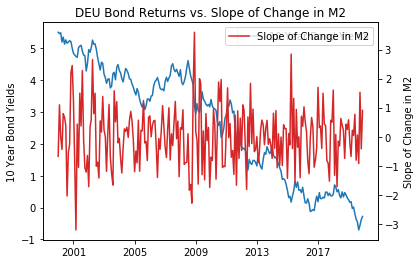

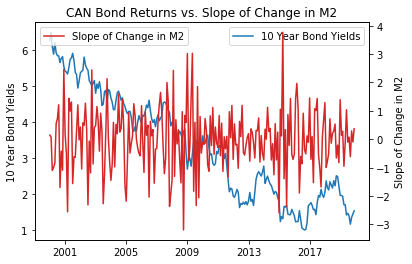

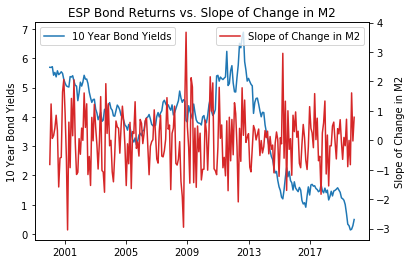

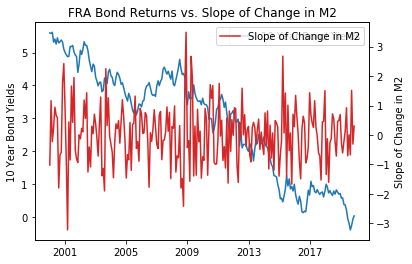

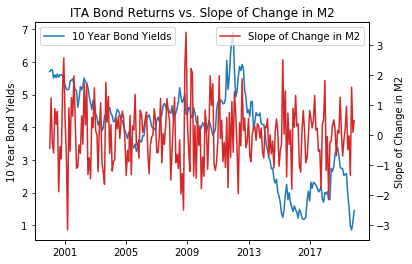

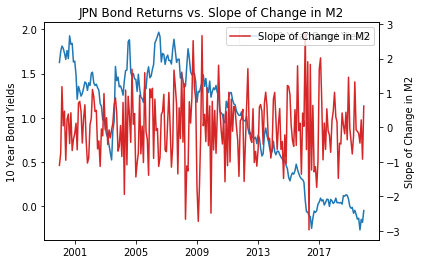

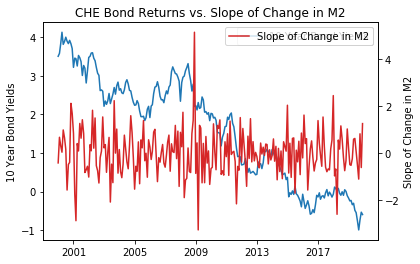

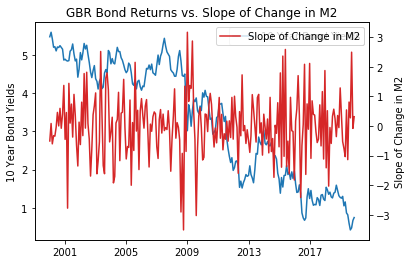

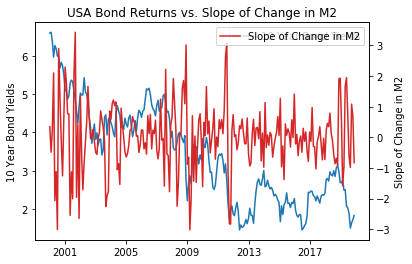

In [617]:
change_m2 = m2.pct_change(1)
smoothed_change_m2 = change_m2.rolling(3).mean()
slope_smoothed_change_m2 = smoothed_change_m2.diff()
rolling_slope = slope_smoothed_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_std = rolling_slope.std()
start_date = '2000-01-01'
end_date = '2019-12-31'
for country in change_m2.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
#     ax1_label = 'Bond Returns'
#     ax1.plot(BondReturnIdx[country].pct_change(1).loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Slope of Change in M2'
    ax2.plot(((slope_smoothed_change_m2)/rolling_slope_std)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Returns vs. Slope of Change in M2")
    plt.show()
    
# print(slope_smoothed_change_m2.loc['2000-01-01':'2009-01-01'].std())
# print(slope_smoothed_change_m2.loc['2011-01-01':'2019-12-31'].std())

**Takeaways**:
- Measure changes in M2 over 1 month rather than 24 months. This is more effective in capturing movements in bond yields when trading (and updating signal) on a daily basis.
    - More intuitively, the state of the money supply and monetary policy 24 months ago may not be a good indicator for near-term movements in money supply. Instead, we can look at the 1 month changes in money supply (and take the derivative) to understand how fast the money supply is growing/shrinking.
    - In order to capture how significant these movements are relative to typical/longer-term deviations in the money supply, the slopes are standardized using a 5-year rolling average of deviations in money supply.
- As a result of the prior change, I will only smooth M2 over the last 3 months (as opposed to 6 months), so as to remove some of the randomness that will affect the derivative of changes in M2 without significantly muting any potentially relevant changes.

#### Investigating Failure Case from Modified Strategy 
- 2018-05

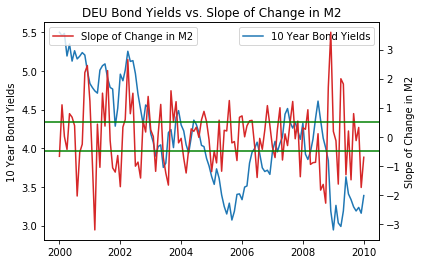

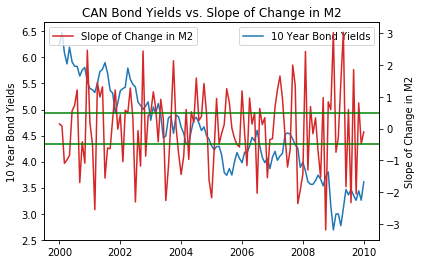

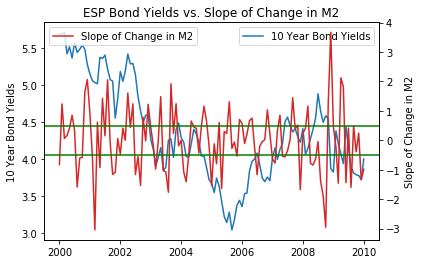

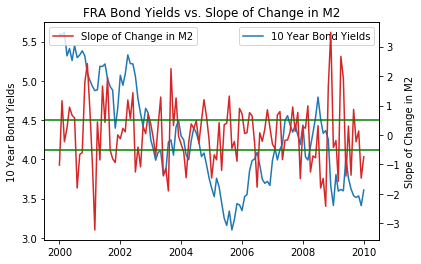

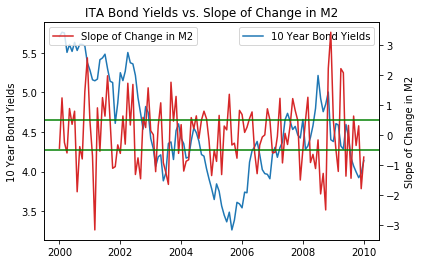

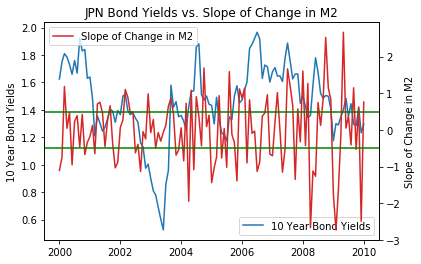

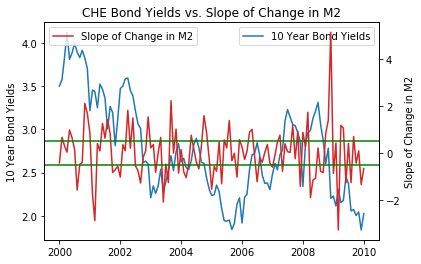

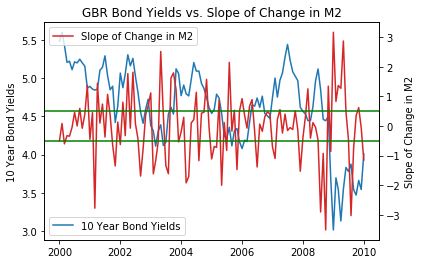

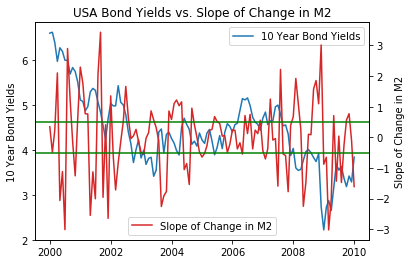

In [587]:
change_m2 = m2.pct_change(1)
smoothed_change_m2 = change_m2.rolling(3).mean()
slope_smoothed_change_m2 = smoothed_change_m2.diff()
rolling_slope = slope_smoothed_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_std = rolling_slope.std()
rolling_slope_std = rolling_slope.std()
upper_boundary_std = 0.5 * rolling_slope_std
lower_boundary_std = -0.5 * rolling_slope_std
start_date = '2000-01-01'
end_date = '2010-01-01'
for country in change_m2.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Slope of Change in M2'
    ax2.plot((slope_smoothed_change_m2/rolling_slope_std)[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
#     ax2.plot(axhline(y=0.5, color='g', linestyle='-'))
#     ax2.plot(axhline(y=-0.5, color='g', linestyle='-'))
    ax2.axhline(y= 0.5, color='g', linestyle='-')
    ax2.axhline(y=-0.5, color='g', linestyle='-')
    ax2.legend()
    plt.title(country + " Bond Yields vs. Slope of Change in M2")
    plt.show()
    
    
#     fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
#     ax1_label = '10 Year Bond Yields'
#     ax1.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
#     ax1.set_ylabel(ax1_label)
#     ax1.legend()
#     ax2_label = 'Change in M2'
#     ax2.plot(change_m2[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
#     ax2.set_ylabel(ax2_label)
#     ax2.legend()
#     plt.title(country + " Bond Yields vs. Change in M2")
#     plt.show()

**Takeaways**:
- This seems to be an instance in which the model benefits from reacting to the most recent changes in M2. (We are holding the prior position instead of updating to the most current slope.) We see this improvement in performance (for this specific case) when we reduce the smoothing period of changes in M2 from 3 months to 2 months. However this change comes at the cost of the total P&L (15.85 vs. 28.64 total P&L between 2015 - 2019).
- In general (and from a logical perspective), we do not want the temporary adjustments in M2 changes to radically affect our views. I would expect that shifts in monetary policy are carried out by the Fed over the course of several months, so smoothing helps capture the Fed's overarching response to the underlying conditions of the economy. 
- Due to this tradeoff, I will continue to smooth the changes in M2 over 3 months as opposed to a shorter period of time.

#### Including Australia - how to estimate slope of changes in M2

##### Option 1: Average(M1, M3) and Standardized Compare Slope(% Change)

In [476]:
est = (m1 + m3)/2
change_est_m2 = est.pct_change(1)
smoothed_est_change_m2 = change_est_m2.rolling(3).mean()
slope_smoothed_est_change_m2 = smoothed_est_change_m2.diff()
rolling_slope_est = slope_smoothed_est_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_std_est = rolling_slope_est.std()

change_m2 = m2.pct_change(1)
smoothed_change_m2 = change_m2.rolling(3).mean()
slope_smoothed_change_m2 = smoothed_change_m2.diff()
rolling_slope = slope_smoothed_change_m2.rolling(5*12, min_periods = 12*2)
rolling_slope_std = rolling_slope.std()

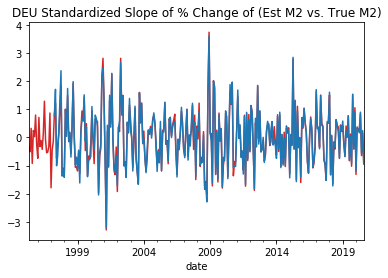

0.11265015244738882


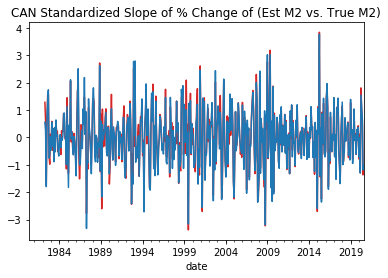

0.16494749602969053


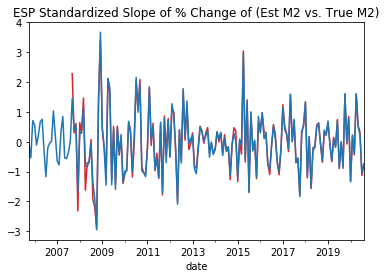

0.1047846433053945


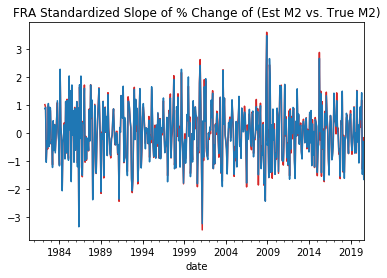

0.09398097458601466


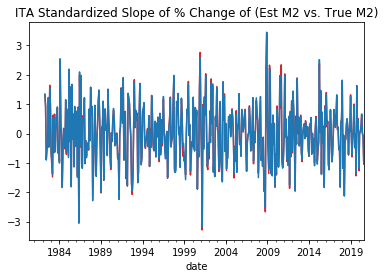

0.06748774991940722


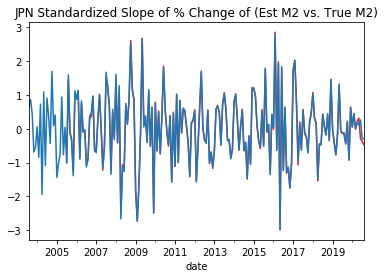

0.04018352370135729


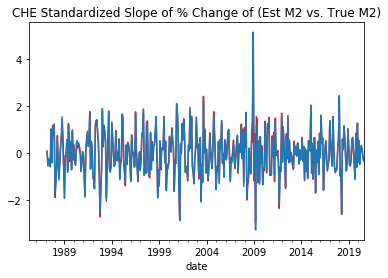

0.08571811209291258


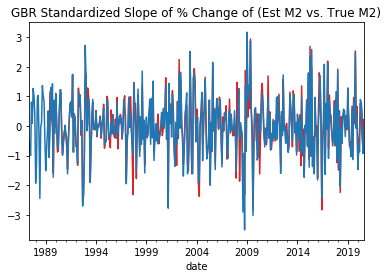

0.24810013245819043
avg diff across countries
0.1147315980675445


In [490]:
sum_diffs = 0
for country in m2.columns.drop("USA"):
    #available time period of data differs - find intersection of time periods 
    est_index = slope_smoothed_est_change_m2[country].dropna(how='all').index
    real_index = slope_smoothed_change_m2[country].dropna(how='all').index
    comparable_index = est_index.intersection(real_index)
    
    standardized_slopes_est = (slope_smoothed_est_change_m2[country] / rolling_slope_std_est[country])
    standardized_slopes = (slope_smoothed_change_m2[country]/rolling_slope_std[country])
    standardized_slopes_est.loc[comparable_index].plot(color = 'tab:red')
    standardized_slopes.loc[comparable_index].plot(color = 'tab:blue')
    plt.title(country + " Standardized Slope of % Change of (Est M2 vs. True M2)")
    plt.show()
    
    diff_value = (standardized_slopes_est.loc[comparable_index] - standardized_slopes.loc[comparable_index]).abs()
    mean_diff_value = diff_value.mean()
    sum_diffs += mean_diff_value
    print(mean_diff_value)
print("avg diff across countries")
print(sum_diffs / len(m2.columns.drop("USA")))

##### Option 2: Compare M3 Standardized Slope(% Change) to that of M2

In [477]:
change_m3 = m3.pct_change(1)
smoothed_change_m3 = change_m3.rolling(3).mean()
slope_smoothed_change_m3 = smoothed_change_m3.diff()
rolling_slope_m3 = slope_smoothed_change_m3.rolling(5*12, min_periods = 12*2)
rolling_slope_m3_std = rolling_slope_m3.std()

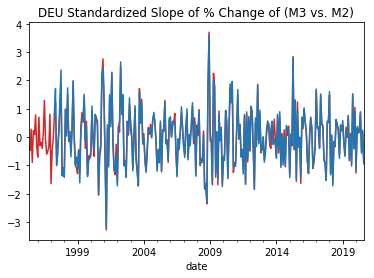

0.10712641694582921


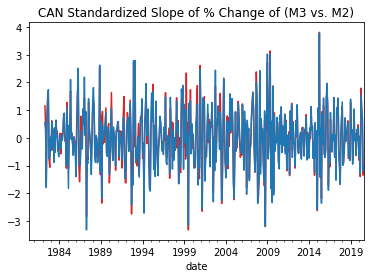

0.1916514797656929


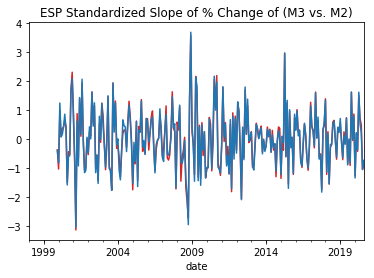

0.10970793149784933


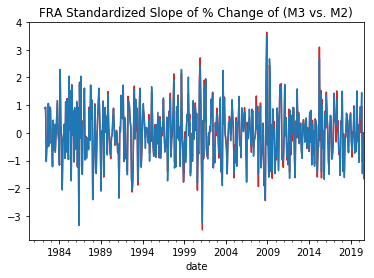

0.1262395236703757


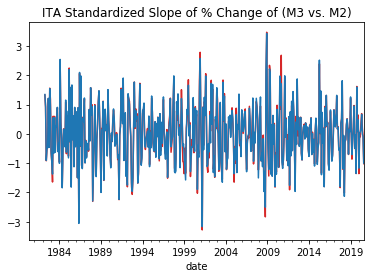

0.09268826906684148


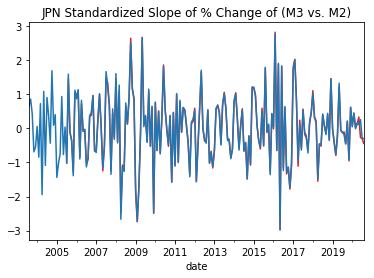

0.04888065394278628


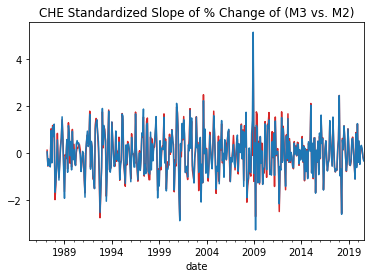

0.13111211919743038


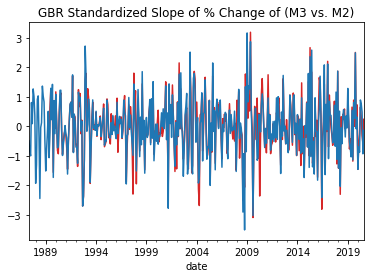

0.25971736601072304
avg diff across countries
0.13339047001219104


In [488]:
sum_diffs = 0
for country in m2.columns.drop("USA"):
    #available time period of data differs - find intersection of time periods 
    est_index = slope_smoothed_change_m3[country].dropna(how='all').index
    real_index = slope_smoothed_change_m2[country].dropna(how='all').index
    comparable_index = est_index.intersection(real_index)
    
    standardized_slopes_m3 = (slope_smoothed_change_m3[country] / rolling_slope_m3_std[country])
    standardized_slopes = (slope_smoothed_change_m2[country]/rolling_slope_std[country])
    standardized_slopes_m3.loc[comparable_index].plot(color = 'tab:red')
    standardized_slopes.loc[comparable_index].plot(color = 'tab:blue')
    plt.title(country + " Standardized Slope of % Change of (M3 vs. M2)")
    plt.show()
    
    diff_value = (standardized_slopes_m3.loc[comparable_index] - standardized_slopes.loc[comparable_index]).abs()
    mean_diff_value = diff_value.mean()
    sum_diffs += mean_diff_value
    print(mean_diff_value)
print("avg diff across countries")
print(sum_diffs / len(m2.columns.drop("USA")))

##### Option 3: Compare M1 Standardized Slope(% Change) to that of M2

In [481]:
change_m1 = m1.pct_change(1)
smoothed_change_m1 = change_m1.rolling(3).mean()
slope_smoothed_change_m1 = smoothed_change_m1.diff()
rolling_slope_m1 = slope_smoothed_change_m1.rolling(5*12, min_periods = 12*2)
rolling_slope_m1_std = rolling_slope_m1.std()

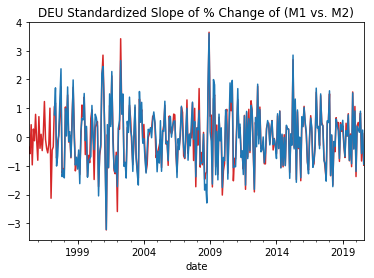

0.19915849201740182


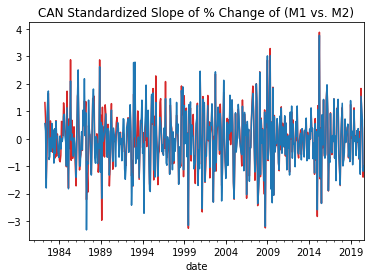

0.22623337317859052


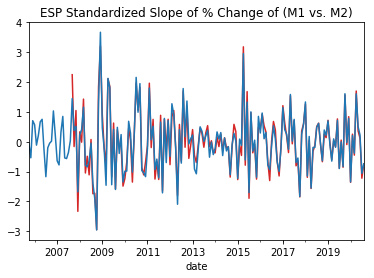

0.1712279723275551


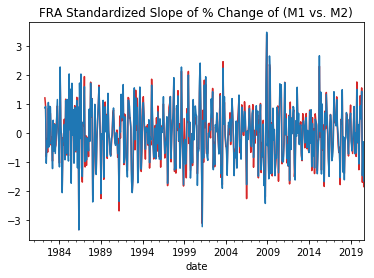

0.15367509264180268


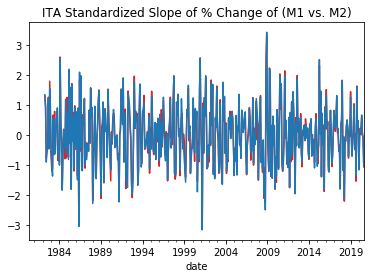

0.10772111349708513


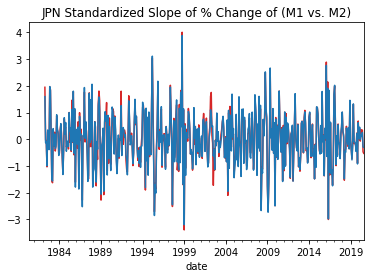

0.11067516232184607


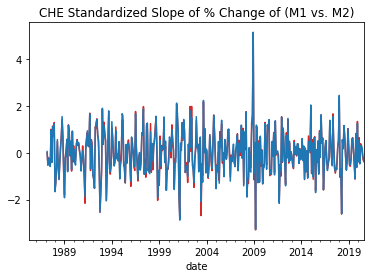

0.10692557376998178


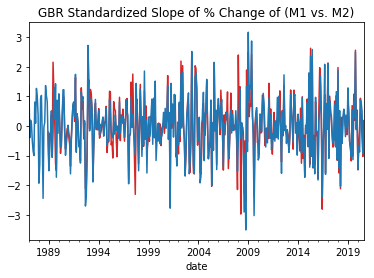

0.30524417394122233


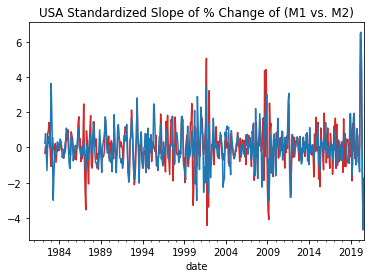

0.7364363362462395
avg diff across countries
0.23525525443796946


In [489]:
sum_diffs = 0
for country in m2.columns:
    #available time period of data differs - find intersection of time periods 
    est_index = slope_smoothed_change_m1[country].dropna(how='all').index
    real_index = slope_smoothed_change_m2[country].dropna(how='all').index
    comparable_index = est_index.intersection(real_index)
    
    standardized_slopes_m1 = (slope_smoothed_change_m1[country] / rolling_slope_m1_std[country])
    standardized_slopes = (slope_smoothed_change_m2[country]/rolling_slope_std[country])
    standardized_slopes_m1.loc[comparable_index].plot(color = 'tab:red')
    standardized_slopes.loc[comparable_index].plot(color = 'tab:blue')
    plt.title(country + " Standardized Slope of % Change of (M1 vs. M2)")
    plt.show()
    
    diff_value = (standardized_slopes_m1.loc[comparable_index] - standardized_slopes.loc[comparable_index]).abs()
    mean_diff_value = diff_value.mean()
    sum_diffs += mean_diff_value
    print(mean_diff_value)
print("avg diff across countries")
print(sum_diffs / len(m2.columns))

**Takeaway**: 
Across the board, (option 1) averaging M1 and M3 to calculate the standardized slope of changes in money supply yields the smallest variation from the value calculated using M2 data. For that reason and since the differences in most countries are not large enough to significantly sway the long/short position on Australia bonds, I will use this method to include Australia in the indicator.

#### Modified Indicator with Australia Data

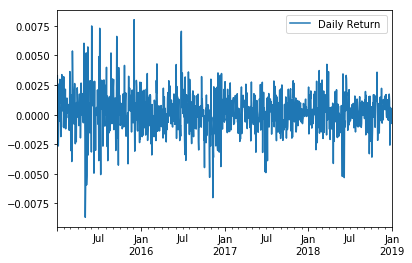

In [555]:
start_date = '1990-01-01'
end_date = '2015-01-01'
trade_date = '2015-01-02'
unwind_date = '2019-01-01'
trade_range = pd.date_range(trade_date, unwind_date, freq='B')
daily_pl = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily P&L"])
prior_weights = pd.Series()
est_aus = ((m1 + m3)/2)['AUS']

long_returns = BondReturnIdx.pct_change(1)
daily_ret = pd.DataFrame(index = trade_range.to_period("B"), columns = ["Daily Return "])
for date in pd.date_range(trade_date, unwind_date, freq='B').date:
    m2_training = m2.loc[start_date:end_date]
    m2_training.loc[:,'AUS'] = est_aus.loc[start_date:end_date]
    change_m2_training = m2_training.pct_change(1)
    smoothed_m2_training = change_m2_training.rolling(3).mean()
    slope_change_m2_training = smoothed_m2_training.diff()

    #standardizing data across time 
    rolling_slope = slope_change_m2_training.rolling(5*12, min_periods = 12*2)
    rolling_slope_std = rolling_slope.std()
    time_standardized_slopes = slope_change_m2_training/rolling_slope_std ##close to a z-score 
    current_slopes = time_standardized_slopes.loc[end_date].sort_values(axis=0, ascending = False)
    
    #hold prior position if the slope is < .5 standard deviations from 0
    if prior_weights.empty:
        prior_weights = current_slopes
    current_slopes = current_slopes.where(current_slopes.abs() > 0.5, prior_weights)
    
    #calculating long positions
    current_slopes_neg = current_slopes.multiply(current_slopes.lt(0))
    sum_neg_weights = current_slopes_neg.sum()
    if sum_neg_weights != 0:
        current_slopes_neg = current_slopes_neg / sum_neg_weights
    buy_amounts = current_slopes_neg 

    #calculating short positions
    current_slopes_pos = current_slopes.multiply(current_slopes.gt(0))
    sum_pos_weights = current_slopes_pos.sum()
    if sum_pos_weights != 0:
        current_slopes_pos = current_slopes_pos / sum_pos_weights
    sell_amounts = -1 * current_slopes_pos 
    positions = buy_amounts + sell_amounts 
    min_val = positions.min()
    max_val = positions.max()
    positions = positions.apply(lambda x: (2 * (x - min_val) / (max_val - min_val)) - 1)
    daily_ret.loc[date] = positions.dot(long_returns.loc[date,]) / positions.abs().sum()
    
    #calculating return 
#     one_day_return = long_returns.loc[date]
#     daily_pl.loc[date,] = buy_amounts.dot(one_day_return) + sell_amounts.dot(-one_day_return)
    #model testing - cases of very poor performance 
#     if daily_pl.loc[date].values < -1:
#         print("failure case")
#         print(buy_amounts)
#         print(one_day_long_return)
#         print(sell_amounts)
#         print(one_day_short_return)
#         print(current_slopes)
    end_date = date
    
daily_ret.plot()
plt.show()

In [584]:
print(daily_ret["Daily Return "].astype('float64').corr(daily_ret["Daily Return "].astype('float64')))

0.9999999999999999


In [579]:
type(daily_ret.astype('float64'))

pandas.core.frame.DataFrame

In [582]:
daily_ret["Daily Return "]

2015-01-02     0.00328956
2015-01-05   -0.000177576
2015-01-06      0.0020366
2015-01-07    -0.00264612
2015-01-08     -0.0010165
2015-01-09     0.00132955
2015-01-12     0.00260522
2015-01-13    0.000988116
2015-01-14     0.00298677
2015-01-15   -0.000561894
2015-01-16    0.000541224
2015-01-19    -0.00185257
2015-01-20    0.000100118
2015-01-21    -0.00105616
2015-01-22      0.0033837
2015-01-23       0.002646
2015-01-26    0.000328018
2015-01-27     0.00255947
2015-01-28    0.000730607
2015-01-29    0.000702804
2015-01-30     0.00320255
2015-02-02    -0.00110866
2015-02-03     0.00171839
2015-02-04     0.00209088
2015-02-05    0.000218053
2015-02-06     0.00214836
2015-02-09    -0.00119562
2015-02-10    3.57621e-05
2015-02-11    0.000433184
2015-02-12   -0.000266501
                 ...     
2018-11-21     0.00073372
2018-11-22    -0.00044219
2018-11-23     0.00127773
2018-11-26    0.000746947
2018-11-27    0.000511962
2018-11-28    0.000627745
2018-11-29     0.00152258
2018-11-30  

In [609]:
daily_ret.resample('Q').sum().mean()

Daily Return     0.014066
dtype: float64

In [624]:
BondReturnIdx.sum()

country
AUS    5334821.513
DEU    2902760.395
CAN    3886745.014
ESP    4433201.732
FRA    3466919.029
ITA    4172295.859
JPN    1949500.746
CHE    2178998.647
GBR    4075797.994
USA    3019413.240
dtype: float64